# Expectation-Maximization Algorithm for Image Segmentation

This notebook implements a Gaussian Mixture Model (GMM) for image segmentation using the Expectation-Maximization algorithm.
It includes both a custom implementation and an option to use scikit-learn's implementation.



## Import Required Libraries

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

use_sklearn = False

## Custom GMM Implementation

Implementation of Gaussian Mixture Model from scratch with detailed documentation

In [2]:
class GaussianMixtureModel_ByHand:
    """
    Gaussian Mixture Model implementation for image segmentation.
    
    This class implements the Expectation-Maximization (EM) algorithm 
    
    Parameters:
        n_components (int): Number of classes(default=2 for foreground/background)
        max_iter (int): Maximum number of iterations (default=100)
    """
    def __init__(self, n_components=2, max_iter=100):
        self.n_components = n_components
        self.max_iter = max_iter
        
    def initialize_parameters(self, X):
        """
        Initialize model parameters randomly from the data.
        
        Args:
            X: Array of shape (n_pixels, n_features) where each row is a pixel's RGB values
        
        Sets:
            self.means: Initial cluster centers, randomly chosen from data points
            self.covs: Initial covariance matrices (identity matrix for each component)
            self.mixing_coefficients: Initial cluster probabilities (uniform)
        """
        n_samples, n_features = X.shape
        
        # Randomly initialize means by selecting a random sample from the data as the mean
        random_idx = np.random.permutation(n_samples)[:self.n_components] # 2 random indices
        self.means = X[random_idx] # 2 random pixels , each pixel has 3 values (RGB) . This is the mean of each feature in the 2 classes
        
        # Initialize covariances
        self.covs = np.array([np.eye(n_features) for _ in range(self.n_components)]) # 3 identity matrices X 2 classes
        
        # Initialize mixing coefficients (mixing_coefficients)
        self.mixing_coefficients = [1/self.n_components] * self.n_components # 2 classes , each class has a probability of 0.5
        
    def gaussian_pdf(self, X, mean, cov):
        """
        Compute multivariate Gaussian probability density function.
        
        Args:
            X: Array of shape (n_pixels, n_features) containing pixel values
            mean: Mean vector of the Gaussian
            cov: Covariance matrix of the Gaussian
            
        Returns:
            Array of probabilities for each pixel belonging to this Gaussian
            
        Notes:
            1. Computes determinant and inverse of covariance matrix
            2. Applies the formula: p(x) = 1/sqrt((2π)^d|Σ|) * exp(-0.5(x-μ)ᵀΣ⁻¹(x-μ))
            3. Handles numerical stability for determinant
        """
        # this is a per class function , it calculates the probability of each pixel to belong to this class
        n_features = X.shape[1]
        det = np.linalg.det(cov)
        if det == 0:
            det = np.finfo(float).eps
            
        norm_const = 1.0 / (np.power(2 * np.pi, n_features/2) * np.sqrt(det))
        inv_cov = np.linalg.inv(cov)
        
        X_mu = X - mean
        exp = -0.5 * np.sum(X_mu.dot(inv_cov) * X_mu, axis=1)
        
        return norm_const * np.exp(exp)
    
    def e_step(self, X):
        """
        Expectation step: compute probability of each pixel belonging to each cluster.
        
        Args:
            X: Array of pixel values
            
        Returns:
            resp: Responsibility matrix of shape (n_pixels, n_components)
                 resp[i,j] = probability that pixel i belongs to cluster j
                 
        Process:
            1. For each component k:
               - Compute p(x|k) using gaussian_pdf
               - Multiply by mixing coefficient πₖ
            2. Normalize probabilities to sum to 1 for each pixel
        """
        n_samples = X.shape[0]
        resp = np.zeros((n_samples, self.n_components))
        
        # Compute probabilities for each component
        for k in range(self.n_components): # sets the values in each column
            resp[:, k] = self.mixing_coefficients[k] * self.gaussian_pdf(X, self.means[k], self.covs[k])
            
        # Normalize responsibilities
        resp_sum = resp.sum(axis=1)[:, np.newaxis] # sum of each row
        resp_sum[resp_sum == 0] = np.finfo(float).eps # if the sum is 0 , set it to a very small number
        resp = resp / resp_sum # divide each value by the sum of its row
        
        return resp
    
    def m_step(self, X, resp):
        """
        Maximization step: update model parameters based on current responsibilities.
        
        Args:
            X: Array of pixel values
            resp: Responsibility matrix from E-step
            
        Updates:
            1. mixing_coefficients: New cluster probabilities (πₖ)
               πₖ = number of pixels in cluster k / total pixels
            
            2. means: New cluster centers (μₖ)
               μₖ = weighted average of pixels, weights = responsibilities
            
            3. covs: New covariance matrices (Σₖ)
               Σₖ = weighted covariance of pixels around mean
            
        Notes:
            Adds small constant to covariance diagonal for stability
        """
        n_samples = X.shape[0]
        
        # Update mixing_coefficients
        nk = resp.sum(axis=0) # sum of each column
        self.mixing_coefficients = nk / n_samples # number of pixels in each class / total number of pixels
        
        # Update means , weighted average based on the probabilities
        """
                X = [                  resp = [
            [R1,G1,B1],           [0.9, 0.1],  # Pixel 1
            [R2,G2,B2],           [0.8, 0.2],  # Pixel 2
            [R3,G3,B3]            [0.1, 0.9]   # Pixel 3
        ]                     ]
        
        nk = [1.8, 1.2]  # Sum of responsibilities for each component
        
        means = [
            [
            (0.9*R1 + 0.8*R2 + 0.1*R3)/1.8,
            (0.9*G1 + 0.8*G2 + 0.1*G3)/1.8,
            (0.9*B1 + 0.8*B2 + 0.1*B3)/1.8
            ],  # Component 1

            [
            (0.1*R1 + 0.2*R2 + 0.9*R3)/1.2,
            (0.1*G1 + 0.2*G2 + 0.9*G3)/1.2,
            (0.1*B1 + 0.2*B2 + 0.9*B3)/1.2
            ]   # Component 2
        ]
        """
        self.means = resp.T.dot(X) / nk[:, np.newaxis] 
        
        # Update covariances
        for k in range(self.n_components):
            X_mu = X - self.means[k]
            self.covs[k] = (X_mu.T * resp[:, k]).dot(X_mu) / nk[k] # weighted covariance of pixels
            
            # Add small value to diagonal for numerical stability & Prevents overfitting to exact color values
            # default value is 1e-6 , set it to 0.1 for more smoothing in the segmentation
            self.covs[k].flat[::X.shape[1] + 1] += 1e-6
    
    def fit(self, X):
        """
        Fit the GMM to the pixel data using EM algorithm.
        
        Args:
            X: Array of pixel values
            
        Process:
            1. Initialize parameters randomly
            2. Repeat until convergence or max_iter:
               - E-step: compute responsibilities
               - M-step: update parameters
               
        Returns:
            self: Trained model
        """
        # Initialize parameters
        self.initialize_parameters(X)
        
        for iteration in range(self.max_iter):
            # E-step
            resp = self.e_step(X) 
            # this returns a 2D array , the rows are the pixels and the columns are the classes
            # each value is the probability of this pixel to belong to that class

            # M-step
            self.m_step(X, resp)
            
        return self
    
    def predict(self, X):
        """
        Predict cluster assignments for pixels.
        
        Args:
            X: Array of pixel values
            
        Returns:
            Array of cluster labels (0 or 1) for each pixel,
            assigned to the component with highest responsibility
        """
        resp = self.e_step(X)
        return resp.argmax(axis=1) # returns the index (0 or 1) of the max value in each row

## Image Segmentation Function

Main function to perform image segmentation using GMM

In [3]:
def GMM (original_image_path):
    image = Image.open(original_image_path)
    image_array = np.array(image)
    height, width, channels = image_array.shape
    # convert the image into pixels 2D array as expected by the model
    pixels = image_array.reshape(-1, channels)

    # 2 components foreground and background so the return is either 0 or 1
    # takes a 2D array were each row is a pixel and each column is a feature (color channel)
    if use_sklearn:
        print("Using sklearn ...")
        gmm = GaussianMixture(n_components=2)
    else:
        print("Using custom implementation ...")
        gmm = GaussianMixtureModel_ByHand(n_components=2)
    gmm.fit(pixels)
    labels = gmm.predict(pixels)

    if np.sum(labels) < len(labels) / 2:
        foreground_label = 1
    else:
        foreground_label = 0

    # create an image with the same size as the original
    # put True/1 in the pixels that are labeled as foreground , False/0 otherwise
    binary_mask = (labels == foreground_label).reshape(height, width)

    # multiply the mask by the original image to get the segmented image
    masked_image = image_array.copy()
    for c in range(channels):
        masked_image[:,:,c] = image_array[:,:,c] * binary_mask

    # covert the 0 and 1 to 0 and 255 by multiplying by 255
    binary_segmented_image = binary_mask * 255  

    # Display the original image and the segmented images
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Original image
    axes[0].imshow(image_array)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Binary mask
    axes[1].imshow(binary_segmented_image, cmap='gray')
    axes[1].set_title('Binary Mask')
    axes[1].axis('off')

    # Masked RGB image
    axes[2].imshow(masked_image)
    axes[2].set_title('Segmented Image')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

## Results


### By sklearn

Using sklearn ...


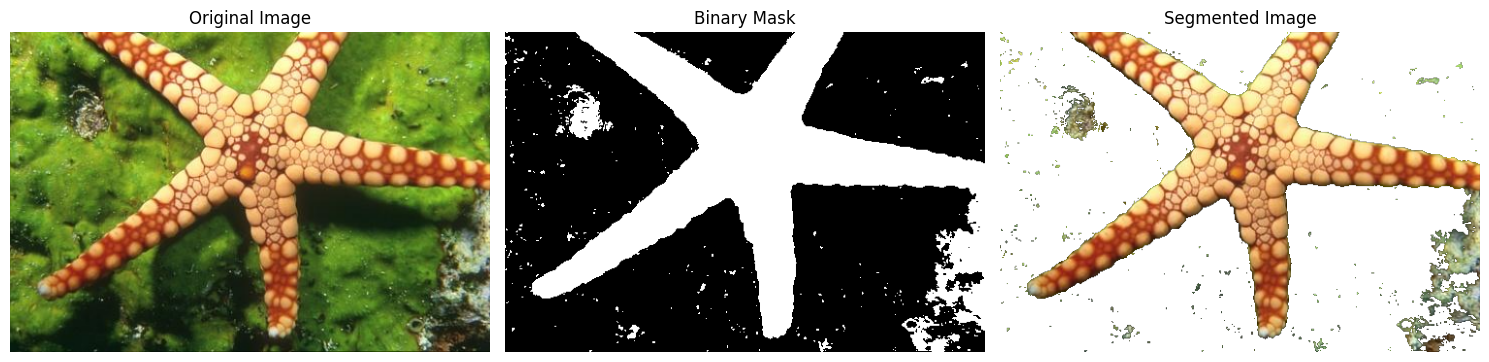

In [4]:
original_image_path = "/media/bahy/MEDO BAHY/CMS/Deep Learning/Assignment 1/expectation-maximization-algorithm/Dataset/model.jpg"
use_sklearn = True
GMM(original_image_path)

### From scratch

Using custom implementation ...


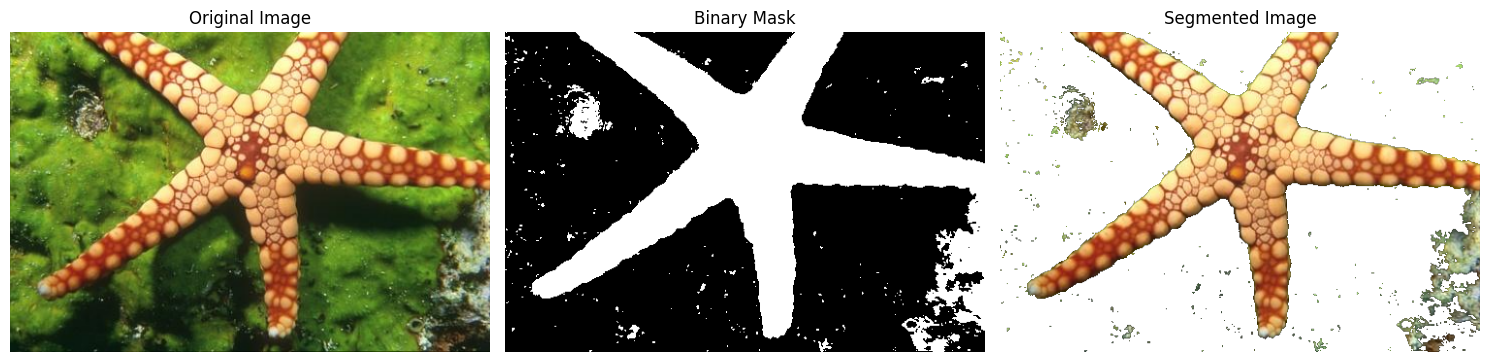

In [6]:
original_image_path = "/media/bahy/MEDO BAHY/CMS/Deep Learning/Assignment 1/expectation-maximization-algorithm/Dataset/model.jpg"
use_sklearn = False
GMM(original_image_path)